In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from gas.PDFs.PDF_3body import PDF3B
from gas.PDFs.PDFs_utils.PDF_show import plot_RDF3b, plot_r1r2_RDF3b

try:
    import cupy as cp
    if cp.cuda.is_available():
        print(f"Found {cp.cuda.runtime.getDeviceCount()} GPUs")
        device = 0
        print(f"Will use GPU {device}")
        cp.cuda.Device(device).use()
    else:
        print("No GPUs found, using CPU")
        device='cpu'
except (ImportError, ModuleNotFoundError):
    print("No GPUs found, using CPU")
    device='cpu'

Found 4 GPUs
Will use GPU 0


# Load data

## a Ta 

In [3]:
file_Ta = Path("/home/arthur/Data/PDFs/structures/a_Ta/Ta_sim_model.xyz")
print(file_Ta.exists())
material = "a_Ta"
pbcs = [1,1,1]

True


In [4]:
class atoms: pass

# Define a generator function to access specific rows in the coordinate text file
def generate_specific_rows(filePath, userows=[]):
    with open(filePath, 'rb') as f:
        for i, line in enumerate(f):
            if i in userows:
                yield line

# Get cell dimensions from 2nd row of the coordinate file.  File uses Prismatic input format: https://prism-em.com/docs-inputs/
atoms.cell = np.eye(3) * np.loadtxt(
    generate_specific_rows(
        file_Ta,
        userows = [1]),
    unpack='true',
)

# Read in all atomic coordinates, and then keep only (x,y,z) coordinates.
atoms.positions = np.genfromtxt(
    file_Ta,
    skip_header=2,
    skip_footer=2,
)[:,1:4]

print(f"total atoms: {atoms.positions.shape[0]}")

total atoms: 1023999


# 3-body PDF from atomic positions


In [5]:
# First run might have warmup, only happens sometimes, but if being very slow on first run
# try using large skip values ~100_000 and just wait a couple minutes. then should be fine.

# ~ 3 sec with r_max = 10, skip = 101, batch size 32 is good
# ~ 50 sec with r_max = 20, skip = 101, batch size 32, weight_subpixel False
# though big batchsizes can slow it down with large rad

dr = 0.1
dtheta = 1
hist_r_max = 15 # 20
batch_size = 32
weight_subpixel = False # slower, just averaging between closest two pixels in r1, r2, theta
skip = 1001

pdf3B = PDF3B(device=device, v=1)

gr = pdf3B.pdf3B(
    atoms,
    dr=dr,
    dtheta=dtheta,
    hist_r_max=hist_r_max,
    skip=skip,
    pbcs=pbcs,
    batch_size=batch_size,
    subpixel_weights=weight_subpixel,
    v=1,
)

if device != "cpu":
    gr = gr.get()

# confirm symmetric
print(np.all([np.allclose(gr[i], gr[i].T, 1e-3) for i in range(len(gr))]))

Cell size (A): [268.6053 268.6053 268.6053]
Using a max radius of 15 A
KDTree calc time: 7.5e-01 s
Num total atoms in sim = 1023999
Skip = 1001, so calculating using 1023 atoms as centers
Final shape will be:  (181, 151, 151)


100%|██████████| 32/32 [00:01<00:00, 16.38it/s]


-- done --
Total time (h:m:s) 0:00:02.837
Center atoms per sec: 360.6

True


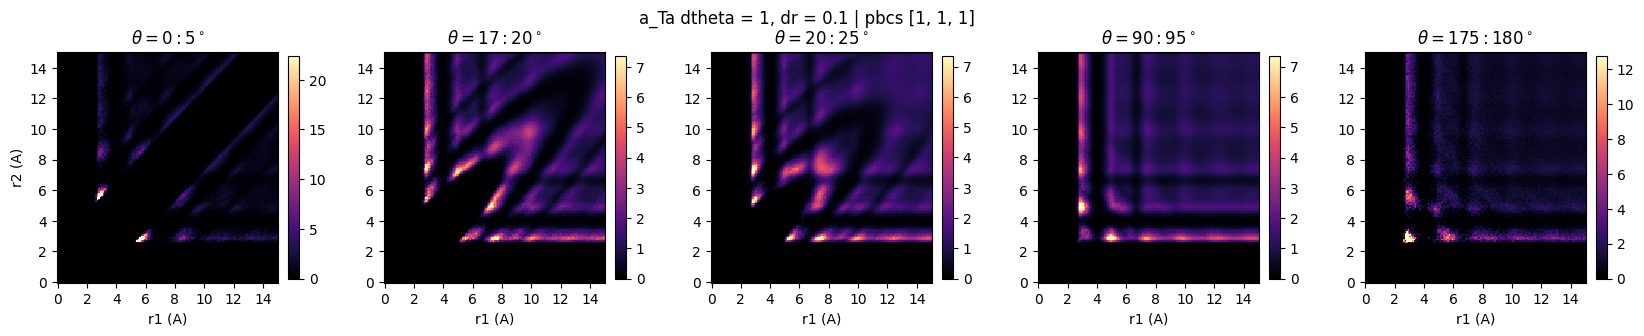

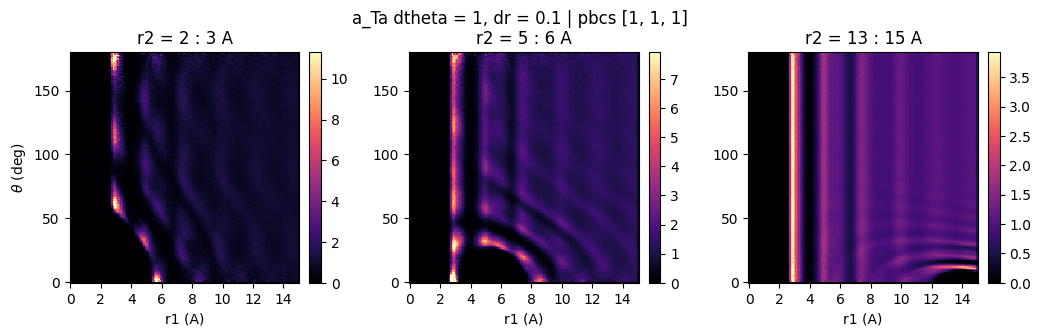

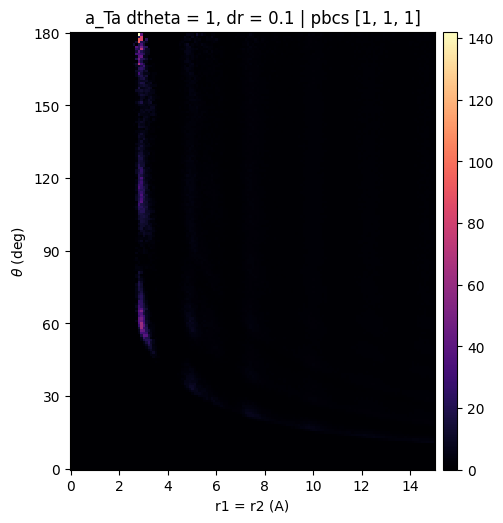

In [6]:
plot_RDF3b(gr, dtheta, dr, theta_slices=[[0, 5], [17,20], [20,25], [90, 95], [175, 180]], cbar=True, title=f"{material} dtheta = {dtheta}, dr = {dr} | pbcs {pbcs}", )
plot_RDF3b(gr, dtheta, dr, r_slices=[[2,3], [5, 6], [hist_r_max-2,hist_r_max]], log=False, cbar=True, title=f"{material} dtheta = {dtheta}, dr = {dr} | pbcs {pbcs}", )
plot_r1r2_RDF3b(gr, dtheta, dr, cbar=True, vmax=50, title=f"{material} dtheta = {dtheta}, dr = {dr} | pbcs {pbcs}")

In [7]:
# ~ 30 sec
dr = 0.1
dtheta = 1
hist_r_max = 30
batch_size = 8
skip = 2001
weight_subpixel = False

gr2 = pdf3B.pdf3B(
    atoms,
    dr=dr,
    dtheta=dtheta,
    hist_r_max=hist_r_max,
    skip=skip,
    pbcs=pbcs,
    batch_size=batch_size,
    subpixel_weights=weight_subpixel,
).get()

Cell size (A): [268.6053 268.6053 268.6053]
Using a max radius of 30 A
KDTree calc time: 1.1e+00 s
Num total atoms in sim = 1023999
Skip = 2001, so calculating using 512 atoms as centers
Final shape will be:  (181, 301, 301)


100%|██████████| 64/64 [00:53<00:00,  1.21it/s]

-- done --
Total time (h:m:s) 0:00:54.237
Center atoms per sec: 9.4



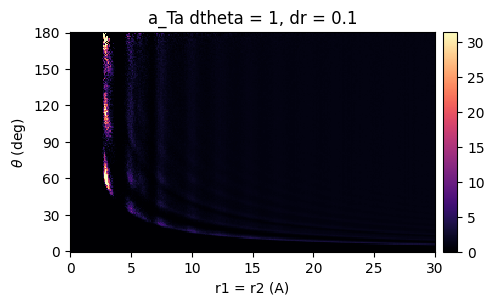

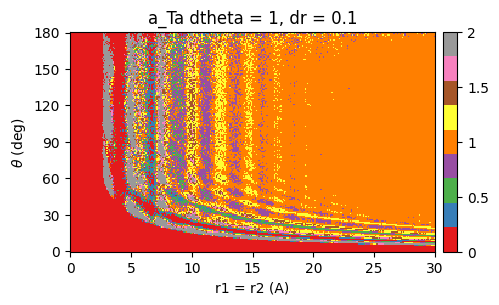

In [8]:
# convergence -> 1 at large r
plot_r1r2_RDF3b(gr2, dtheta, dr, cbar=True, title=f"{material} dtheta = {dtheta}, dr = {dr}", )
plot_r1r2_RDF3b(gr2, dtheta, dr, cmap='Set1', vmax=2, intensity_range='abs', cbar=True, title=f"{material} dtheta = {dtheta}, dr = {dr}", )
